In this project, we will predict the stock price of Google! We will use LSTM for this task. We will make an LSTM that will try to capture the downward and upward tren of the Google stock price. LSTM is the most powerful model that can do this.  

We will train our model on 5-years Google stock price dataset (2012-2016).

We start by data preprocessing,

# 1. Data Preprocessing

### 1.1 Importing the libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1.2 Importing the training set

In [6]:
df_train = pd.read_csv('Google_Stock_Price_Train.csv')

### 1.3 Review data

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
Date      1258 non-null object
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null object
Volume    1258 non-null object
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [8]:
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In our case, we use only the Open values. You can use the others or combine them.

In [46]:
training_set = df_train.iloc[:,1:2].values

In [47]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### 1.4 Feature Scaling

For feature scaling, we will use Normalisation. To do this, we import MinMaxScaler from Scikit-learn library.

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
sc  = MinMaxScaler(feature_range=(0, 1))

In [48]:
training_set_scaled = sc.fit_transform(training_set)

In [49]:
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

### 1.5 Creating a data structure with 60 timesteps and 1 output.
60 times steps here means that at each time T, the RNN is going to look at the 60 stock prices before time T,  that is the stock prices between 60 days before time T and time T, and based on the trends, it is capturing during these 60 previous timesteps, it will try to predict the next output (at time T+1).

And why 60? I tried a lot of number of steps.

Notice that one normal month has 20 financial days. So 60 timesteps here correspond tree months. This means that each day we are gonna look at the __tree previous month__ to try to predict the stock price the __next day__.

Firstly, initializing two empty matrices, 

In [61]:
X_train = []
y_train =  []

Use for loop to append values from *training_set_scaled*  to them,

In [62]:
for i in range(60,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])    

Now, X_train and y_train are lists, we have to transfer them to array, 

In [63]:
type(X_train)

list

In [64]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [65]:
type(X_train)

numpy.ndarray

In [66]:
X_train.shape

(1198, 60)

Now, we use just "Open" column for training set, we can use other indicator (High, Low,...). To do this, you should reshape the dimensionalities of X_train. This change also to be compatible with the input format, input shape in RNN.

(See more at https://keras.io/layers/recurrent/ - Input Shape)
We see that  Input shape is 3D tensor with shape:

<code>(batch_size, timesteps, input_dim)</code>.
    
   + <code>batch_size</code>: number of observations
   + <code>input_dim</code>: number of indicators/predictor

### 1.6 Reshaping

In [67]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [69]:
X_train.shape

(1198, 60, 1)

We have just completed the data preprocessing, the data is ready to train. Now we will build the RNN model.

# 2. Building the RNN model

We are not gonna make a simple LSTM, we are gonna build a stacked LSTM with some dropout regulization to prevent overfitting. We use here the Keras library. 

### 2.1 Importing the Keras libraries and packages

In [73]:
from tensorflow.keras.models import Sequential  #initialize the neural network
from tensorflow.keras.layers import Dense # add the output layer of RNN
from tensorflow.keras.layers import LSTM # add the LSTM layers
from tensorflow.keras.layers import Dropout # add some dropout regularization

### 2.2 Adding layers to RNN

#### Initializing the RNN

In [74]:
regressor = Sequential()

#### Adding the first LSTM layer and some Dropout regularisation

In [75]:
regressor.add(LSTM(units = 50,return_sequences = True,input_shape=(X_train.shape[1],1)))    

W0912 17:46:00.188314 140735623418752 deprecation.py:506] From /Users/PhuocNhatDANG/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


   + <code>units</code>: number of LSTM cells

   + <code>return_sequences</code>: True for non-last LSTM layer, False (Default) for last one.
   + <code>input_shape</code>: Shape of X_train, here we don't need add the 1st dimendion of X_train ( X_train.shape[0]) because it will be automatically taken into account.

We choose <code>units</code> being 50. Since capturing the trends of a stock price is pretty complex, we need to have high dimensionality. Therefore, we need to have a large number of neurons in each of the multiple LSTM layers. 

In [76]:
regressor.add(Dropout(rate = 0.2))

Rate dropout is 20% that means that 20%  of neurons of the LSTM layer will be ignored during the training (during the forward/back propgation) happening in each iteration of the training. In our case, 20% of 50 is 10 neurons.

#### Adding the second LSTM layer and some Dropout regularisation

In [77]:
regressor.add(LSTM(units = 50,return_sequences = True))    

We don't  need input shape anymore!

In [78]:
regressor.add(Dropout(rate = 0.2))

#### Adding the third LSTM layer and some Dropout regularisation

In [79]:
regressor.add(LSTM(units = 50,return_sequences = True))    

In [80]:
regressor.add(Dropout(rate = 0.2))

#### Adding the fourth LSTM layer and some Dropout regularisation

In [81]:
regressor.add(LSTM(units = 50))

<code>return_sequences</code> is False (defaut value) because this is the last LSTM layer.

In [82]:
regressor.add(Dropout(rate = 0.2))

#### Adding the output layer:

In [83]:
regressor.add(Dense(units=1))

### 2.3 Compiling the RNN

In [84]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

The most relevant optimizers for RNN are Adam and RMSprop.

### 2.4 Fitting the RNN model to the Training set

In [85]:
regressor.fit(X_train,y_train, epochs = 100,batch_size = 32)

W0912 19:36:59.526043 140735623418752 deprecation.py:323] From /Users/PhuocNhatDANG/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
1198/1198 [==============================] - 11s 9ms/sample - loss: 0.0522
Epoch 2/100
1198/1198 [==============================] - 9s 7ms/sample - loss: 0.0057
Epoch 3/100
1198/1198 [==============================] - 8s 7ms/sample - loss: 0.0054
Epoch 4/100
1198/1198 [==============================] - 8s 7ms/sample - loss: 0.0055
Epoch 5/100
1198/1198 [==============================] - 8s 7ms/sample - loss: 0.0049
Epoch 6/100
1198/1198 [==============================] - 9s 7ms/sample - loss: 0.0046
Epoch 7/100
1198/1198 [==============================] - 9s 7ms/sample - loss: 0.0045
Epoch 8/100
1198/1198 [==============================] - 9s 8ms/sample - loss: 0.0044
Epoch 9/100
1198/1198 [==============================] - 11s 9ms/sample - loss: 0.0045
Epoch 10/100
1198/1198 [==============================] - 10s 9ms/sample - loss: 0.0047
Epoch 11/100
1198/1198 [==============================] - 8s 7ms/sample - loss: 0.0037
Epoch 12/100
1198/1198 [=========================

1198/1198 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 96/100
1198/1198 [==============================] - 7s 6ms/sample - loss: 0.0016
Epoch 97/100
1198/1198 [==============================] - 8s 6ms/sample - loss: 0.0016
Epoch 98/100
1198/1198 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 99/100
1198/1198 [==============================] - 7s 6ms/sample - loss: 0.0015
Epoch 100/100
1198/1198 [==============================] - 8s 6ms/sample - loss: 0.0013


Here,             
    - bacth_size: the number of observations after  which you want to update the weights
     - epochs : number of rounds that the whole training set pass through the RNN

# 3. Making the predictions and visualizing the results

### 3.1 Getting the real stock price of 2017

In [86]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [87]:
real_stock_price = df_test.iloc[:,1:2].values

In [88]:
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

### 3.2  Getting the predicted stock price of 2017

Tree points you have to notice in this section:

    1. For predicting the stock price in test set, we need some days from training set. We need stock price of 60 previous financial  days to predict stock price at actual day. 
    2. To do this, we need both training set and test set. Therefore, we will concatenate the training and the test set.
    3. DO NOT concatenate training_set (scaled training set) and real_stock_price (test set) since we have to scale this concatenation and this makes change the values of actual test values (real_stock_price). NEVER DO THIS!!! For handling this problem, we will concatenate the two original DataFrames df_train and df_test. We will scale this concatenation and use this to predict the stoke price in January 2017.

In [92]:
dataset_total = pd.concat((df_train["Open"],df_test["Open"]), axis=0)

In [97]:
dataset_total.shape

(1278,)

In [108]:
inputs = dataset_total[len(df_train)-60:].values
#or inputs = dataset_total[len(dataset_total)-len(df_set)-60:].values

In [111]:
inputs.shape

(80,)

Shape of inputs is not a Numpy array, so we need to reshape it.

In [112]:
inputs = inputs.reshape(-1,1) #-1 means None

In [113]:
inputs.shape

(80, 1)

Now, we scale our inputs as the same way applied on training_set

In [114]:
inputs = sc.transform(inputs) 
# no fit since we use exactly the same scaling of training_set.

Next, we are also creating a test data structure with 60 timesteps.

Firstly, initializing an empty matrices, 

In [115]:
X_test = []

Use for loop to append values from *inputs*  to X_test,

In [117]:
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])

In [119]:
type(X_test)

list

We have to transfer X_test to array, 

In [121]:
X_test = np.array(X_test)

In [122]:
type(X_test)

numpy.ndarray

In [123]:
X_test.shape

(20, 60)

We have to reshape X_test to 3D tensor for being compatible with input shape of the RNN.

In [124]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


In [126]:
X_test.shape

(20, 60, 1)

Now, time to predict,

In [129]:
predicted_stock_price = regressor.predict(X_test)

In [130]:
predicted_stock_price

array([[0.9622828 ],
       [0.95715237],
       [0.95670164],
       [0.9592236 ],
       [0.96536624],
       [0.97602963],
       [0.98664725],
       [0.9919952 ],
       [0.99306726],
       [0.9923793 ],
       [0.99160004],
       [0.99102783],
       [0.99069667],
       [0.9914814 ],
       [0.99312484],
       [1.0006243 ],
       [1.0130391 ],
       [1.0272171 ],
       [1.0362607 ],
       [1.0311396 ]], dtype=float32)

However, the values of predicted_stock_price are derived by using the scaled test data (X_test). Therefore, for comparing predicted_stock_price to real_stock_price, we need to inverse our predictions (predicted_stock_price) to original scaling.

In [131]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [132]:
predicted_stock_price

array([[796.4047 ],
       [793.6468 ],
       [793.4045 ],
       [794.76025],
       [798.06226],
       [803.7945 ],
       [809.5021 ],
       [812.37695],
       [812.9532 ],
       [812.5834 ],
       [812.1645 ],
       [811.8569 ],
       [811.6789 ],
       [812.1007 ],
       [812.9842 ],
       [817.01556],
       [823.6893 ],
       [831.31085],
       [836.1723 ],
       [833.4194 ]], dtype=float32)

# 4. Visualising the results

###  Plot the real-predicted stock price

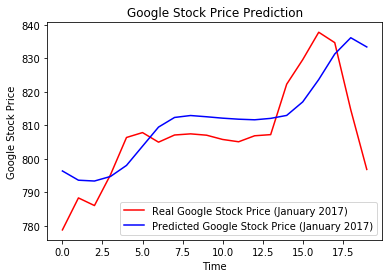

In [133]:
plt.plot(real_stock_price, color = 'red',label = 'Real Google Stock Price (January 2017)')
plt.plot(predicted_stock_price, color = 'blue',label = 'Predicted Google Stock Price (January 2017)')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

From the above plot, we get conclusion:
    
    1. In the parts of the predictions containing some spikes, our predictions lag behind the actual values because our model cannot react to fast, nonlinear changes.

    2. On the other hand, for the parts of the predictions containing smooth changes, our model reacts pretty well and manages to follow the upward and downward trends.

# 5. Improving our model.
Here are different ways to improve the RNN model:

    1. Getting more training data: we trained our model on the past 5 years of the Google Stock Price but it would be even better to train it on the past 10 years.

    2. Increasing the number of timesteps: the model remembered the stock prices from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 timesteps (3 months). You could try to increase the number of timesteps, by choosing for example 120 timesteps (6 months).
    
    3. Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

    4. Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

    5. Adding more neurones in the LSTM layers: we highlighted the fact that we needed a high number of neurones in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurones in each of our 4 LSTM layers. You could try an architecture with even more neurones in each of the 4 (or more) LSTM layers.